<a href="https://colab.research.google.com/github/PsorTheDoctor/Sekcja-SI/blob/master/machine_learning/reinforcement_learning/reinforce/reinforce_cartpole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# REINFORCE
## Ustawienia

In [1]:
try:
  %tensorflow_version 2.x
except:
  pass

TensorFlow 2.x selected.


In [0]:
!sudo apt-get install -y xvfb ffmpeg
!pip install 'gym==0.10.11'
!pip install 'imageio==2.4.0'
!pip install PILLOW
!pip install 'pyglet==1.3.2'
!pip install pyvirtualdisplay
!pip install --upgrade tensorflow-probability
!pip install tf-agents

In [19]:
from __future__ import absolute_import, division, print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay

import tensorflow as tf

from tf_agents.agents.reinforce import reinforce_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym, tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import actor_distribution_network
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

tf.compat.v1.enable_v2_behavior()

# Ustawienie virtual display do renderowania środowisk OpenAI gym.
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


## Hiperparametry

In [0]:
env_name = 'CartPole-v0'
num_iterations = 250
collect_episodes_per_iteration = 2
replay_buffer_capacity = 2000

fc_layer_params = (100,)

learning_rate = 1e-3
log_interval = 25
num_eval_episodes = 10
eval_interval = 50

## Środowisko

In [10]:
env = suite_gym.load(env_name)
env.reset()

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


TimeStep(step_type=array(0, dtype=int32), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([-0.04166482,  0.04906182,  0.0244216 , -0.02906699], dtype=float32))

In [11]:
print('Observation Spec:')
print(env.time_step_spec().observation)
print('Action Spec:')
print(env.action_spec())

Observation Spec:
BoundedArraySpec(shape=(4,), dtype=dtype('float32'), name='observation', minimum=[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], maximum=[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38])
Action Spec:
BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=1)


In [12]:
time_step = env.reset()
print('Krok czasowy:')
print(time_step)

action = np.array(1, dtype=np.int32)

next_time_step = env.step(action)
print('Następny krok czasowy:')
print( next_time_step)

Krok czasowy:
TimeStep(step_type=array(0, dtype=int32), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([0.02707787, 0.03075384, 0.03698024, 0.01995714], dtype=float32))
Następny krok czasowy:
TimeStep(step_type=array(1, dtype=int32), reward=array(1., dtype=float32), discount=array(1., dtype=float32), observation=array([ 0.02769295,  0.22532648,  0.03737938, -0.26083255], dtype=float32))


In [13]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


## Agent

In [0]:
actor_net = actor_distribution_network.ActorDistributionNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params)

In [0]:
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.compat.v2.Variable(0)

tf_agent = reinforce_agent.ReinforceAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    actor_network=actor_net,
    optimizer=optimizer,
    normalize_returns=True,
    train_step_counter=train_step_counter)
tf_agent.initialize()

## Polityki

In [0]:
eval_policy = tf_agent.policy
collect_policy = tf_agent.collect_policy

## Metryki i ocena

In [0]:
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0 

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]

## Bufor odtwarzania

In [0]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec = tf_agent.collect_data_spec,
    batch_size = train_env.batch_size,
    max_length = replay_buffer_capacity)

## Gromadzenie danych

In [0]:
def collect_episode(environment, policy, num_episodes):

  episode_counter = 0
  environment.reset()

  while episode_counter < num_episodes:
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = environment.step(action_step.action)
    traj = trajectory.from_transition(time_step, action_step, next_time_step)
  
    replay_buffer.add_batch(traj)

    if traj.is_boundary():
      episode_counter += 1

## Trenowanie agenta
Uruchomienie zajmie ok. 3 min.

In [38]:
try:
  %%time
except:
  pass

tf_agent.train = common.function(tf_agent.train)

tf_agent.train_step_counter.assign(0)

# Ocena polityki agenta jednorazowo przed treningiem.
avg_return = compute_avg_return(eval_env, tf_agent.policy, num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):

  # Zgromadzenie kilku epizodów z użyciem collect_policy i zapisanie ich do buforu odtwarzania (replay_buffer).
  collect_episode(
      train_env, tf_agent.collect_policy, collect_episodes_per_iteration)

  # Użycie danych z bufora i aktualizacja sieci agenta.
  experience = replay_buffer.gather_all()
  train_loss = tf_agent.train(experience).loss
  replay_buffer.clear()

  step = tf_agent.train_step_counter.numpy()

  if step % log_interval ==  0:
    print('step = {0}: loss = {1}'.format(step, train_loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, tf_agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.48 µs
step = 25: loss = 0.7998112440109253
step = 50: loss = -1.7507457733154297
step = 50: Average Return = 90.69999694824219
step = 75: loss = 0.14396381378173828
step = 100: loss = -3.481363296508789
step = 100: Average Return = 181.3000030517578
step = 125: loss = -4.069250106811523
step = 150: loss = -3.1988821029663086
step = 150: Average Return = 200.0
step = 175: loss = -4.81304931640625
step = 200: loss = -2.5577850341796875
step = 200: Average Return = 200.0
step = 225: loss = 3.189206123352051
step = 250: loss = 5.529643535614014
step = 250: Average Return = 200.0


## Wizualizacja
### Wykresy

(85.2349967956543, 250.0)

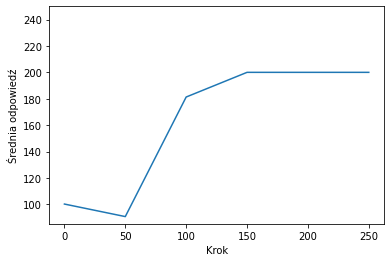

In [43]:
steps = range(0, num_iterations + 1, eval_interval)
plt.plot(steps, returns)
plt.ylabel('Średnia odpowiedź')
plt.xlabel('Krok')
plt.ylim(top=250)

### Wideo

In [0]:
def embed_mp4(filename):
  '''Otwiera plik mp4 w notebooku.'''
  video = open(filename, 'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

In [48]:
num_episodes = 3
video_filename = 'imageio.mp4'
with imageio.get_writer(video_filename, fps=60) as video:
  for _ in range(num_episodes):
    time_step = eval_env.reset()
    video.append_data(eval_py_env.render())
    while not time_step.is_last():
      action_step = tf_agent.policy.action(time_step)
      time_step = eval_env.step(action_step.action)
      video.append_data(eval_py_env.render())

embed_mp4(video_filename)